In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import UnivariateSpline
from scipy.stats import sem
from matplotlib.patches import Circle
from sklearn.linear_model import LinearRegression, RidgeCV
from my_utils import *

from pathlib import Path
import sys
import warnings

In [2]:
modelpath = Path('../model')
sys.path.append(str(modelpath))
import config.config as config

arg = config.ConfigGain()
arg.device = 'cpu'
arg.process_gain_range = [1, 1]

In [3]:
# monkey data path
monkey_data_path = Path('../data/monkey_data')
# agents checkpoints path
progress_agents_path = Path('../data/agents')
# agents checkpoints performance path
training_curve_path = Path('../data/training_curve')
# figure path
figure_path = Path('../paper_figures/figure1&3')

# Load monkey data

In [4]:
data_path = monkey_data_path / 'Bruno'
bruno_normal_trajectory = pd.read_pickle(data_path / 'bruno_normal_trajectory_paper.pkl')

data_path = monkey_data_path / 'Schro'
schro_normal_trajectory = pd.read_pickle(data_path / 'schro_normal_trajectory_paper.pkl')

In [5]:
EPISODE_SIZE = 2000
bruno_normal_trajectory, schro_normal_trajectory = match_similar_trials(bruno_normal_trajectory, 
                                                                        schro_normal_trajectory,
                                                                        is_sort=True, EPISODE_SIZE=EPISODE_SIZE)
bruno_normal_trajectory.reset_index(drop=True, inplace=True)
schro_normal_trajectory.reset_index(drop=True, inplace=True)

# Select agent checkpoints for analyses

In [6]:
def select_agents(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain'):
    perform_files = [[pd.read_csv(file)[(pd.read_csv(file).task == 'gain1x') & 
                                        (pd.read_csv(file).episode < MAX_TRAINING_T) &
                                        (pd.read_csv(file).episode > 0)] 
                      for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
                     for agent_arch in agent_archs]
    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    best_seeds = [seed[np.argmax([file.reward_rate.max() for file in perform_file])] 
                  for perform_file, seed in zip(perform_files, seeds)]
    best_files_idx = [np.argmax([file.reward_rate.max() for file in perform_file]) 
                      for perform_file in perform_files]
    
    best_paths = [progress_agents_path / agent_arch / task / f'seed{seed}'
                  for agent_arch, seed in zip(agent_archs, best_seeds)]
    
    best_episodes = [perform_file[file_idx].sort_values('reward_rate').iloc[-1].episode
                     for perform_file, file_idx in zip(perform_files, best_files_idx)]

    best_agents = [list(best_path.glob(f'*-{best_episode}.*'))[0].stem.split('.')[0]
                   for best_path, best_episode in zip(best_paths, best_episodes)]
    
    perform_files = [[pd.read_csv(file)[(pd.read_csv(file).task == 'gain1x') & 
                                        (pd.read_csv(file).ordered_episode < MAX_TRAINING_T)] 
                      for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
                     for agent_arch in agent_archs]
    
    return best_seeds, best_paths, best_agents, perform_files

In [7]:
Models = {'Holistic_Actor': 'Actor1', 'Holistic_Critic': 'Critic1',
          'Modular_Actor': 'Actor3', 'Modular_Critic': 'Critic5', 
          'EKF_Actor': 'ActorEKF'}
for k, v in Models.items():
    if v[-1].isdigit():
        exec(f'from {v} import {v[:-1]} as {k}')
    else:
        exec(f'from {v} import {v[:-3]} as {k}')

agent_archs = [Models['Holistic_Actor'] + Models['Holistic_Critic'], 
               Models['Modular_Actor'] + Models['Holistic_Critic'],
               Models['Holistic_Actor'] + Models['Modular_Critic'],
               Models['Modular_Actor'] + Models['Modular_Critic']]

MAX_TRAINING_T = 1e4

In [8]:
best_seeds, best_paths, best_agents, perform_files = select_agents(progress_agents_path, 
                                                                   agent_archs, 
                                                                   MAX_TRAINING_T=MAX_TRAINING_T)

In [9]:
def select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain'):    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_ in zip(agent_archs, seeds): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / task / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.task == 'gain1x')
                                        & (perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            best_episode = perform_file.sort_values('reward_rate').iloc[-1].episode
            
            agent_path.append(progress_agents_path / agent_arch / task / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    
    return agent_paths, agent_files

In [10]:
agent_paths, agent_files = select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain')

In [11]:
holistic_agent_archs = [Models['EKF_Actor'] + Models['Holistic_Critic']]

In [12]:
def select_agents_all_holistic(progress_agents_path, agent_archs, MAX_TRAINING_T, tasks=['gain'], subtasks=['']):
    perform_files = [[pd.read_csv(file)[(pd.read_csv(file).task == 'gain1x') & 
                                        (pd.read_csv(file).episode < MAX_TRAINING_T) &
                                        (pd.read_csv(file).episode > 0)] 
                      for file in (training_curve_path / task / subtask).glob(f'{agent_arch}_*.*')] 
                     for agent_arch, task, subtask in zip(agent_archs, tasks, subtasks)]
    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task / subtask).glob(f'{agent_arch}_*.*')] 
             for agent_arch, task, subtask in zip(agent_archs, tasks, subtasks)]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_, task, subtask in zip(agent_archs, seeds, tasks, subtasks): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / task / subtask / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.task == 'gain1x')
                                        & (perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            best_episode = perform_file.sort_values('reward_rate').iloc[-1].episode
            
            if 'full' in task:
                agent_path.append(progress_agents_path.parent / 'agents_all' / agent_arch / task.split('_')[0] / f'seed{seed}')
            else:
                agent_path.append(progress_agents_path / agent_arch / task / subtask / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    
    return agent_paths, agent_files, perform_files

In [13]:
agent_paths_holistic, agent_files_holistic, perform_files_holistic = select_agents_all_holistic(progress_agents_path, 
                                                                                                holistic_agent_archs, 
                                                                                                MAX_TRAINING_T, 
                                                                                                tasks=['gain'],
                                                                                                subtasks=[''])

# Run agents

In [14]:
from Agent_RNN import *
from Environment import Env

In [15]:
# load target positions from monkey data 
target_positions = torch.tensor(bruno_normal_trajectory.loc[:, ('target_x', 'target_y')].values.T, 
                                dtype=torch.float32) / arg.LINEAR_SCALE
target_positions = torch.chunk(target_positions, EPISODE_SIZE, dim=1)

In [16]:
def RNN_agent_simulation(agent):
    reset_seeds(0)
    env = Env(arg)

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []
    pos_theta = []; pos_r_end = []; pos_theta_end = []; pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []

    for target_position in target_positions:
        cross_start_threshold = False
        x = env.reset(target_position=target_position)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            states.append(state)
            actions.append(action)
            
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

            if is_stop and cross_start_threshold:
                break

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))

        state_.append(torch.cat(states))
        
        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())

        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, state=state_, action=action_))

In [17]:
modular_idx = 3
filename_modular, arg.SEED_NUMBER = best_agents[modular_idx], int(best_seeds[modular_idx])
modular_agent = Agent(arg, Modular_Actor, Modular_Critic)
modular_agent.data_path = best_paths[modular_idx]
modular_agent.load(filename_modular, load_memory=False, load_optimzer=False)

holistic_idx = 0
filename_holistic, arg.holistic_SEED_NUMBER = best_agents[holistic_idx], int(best_seeds[holistic_idx])
holistic_agent = Agent(arg, Holistic_Actor, Holistic_Critic)
holistic_agent.data_path = best_paths[holistic_idx]
holistic_agent.load(filename_holistic, load_memory=False, load_optimzer=False)

In [18]:
modular_trajectory, holistic_trajectory = map(RNN_agent_simulation, [modular_agent, holistic_agent])

In [19]:
moho_idx = 1
filename_moho = best_agents[moho_idx]
moho_agent = Agent(arg, Modular_Actor, Holistic_Critic)
moho_agent.data_path = best_paths[moho_idx]
moho_agent.load(filename_moho, load_memory=False, load_optimzer=False)

homo_idx = 2
filename_homo = best_agents[homo_idx]
homo_agent = Agent(arg, Holistic_Actor, Modular_Critic)
homo_agent.data_path = best_paths[homo_idx]
homo_agent.load(filename_homo, load_memory=False, load_optimzer=False)

In [20]:
moho_trajectory, homo_trajectory = map(RNN_agent_simulation, [moho_agent, homo_agent])

In [21]:
modular_agents = []
for agent_path, agent_file in zip(agent_paths[modular_idx], agent_files[modular_idx]):
    modular_agent_ = Agent(arg, Modular_Actor, Modular_Critic)
    modular_agent_.data_path = agent_path
    modular_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    modular_agents.append(modular_agent_)
    
holistic_agents = []
for agent_path, agent_file in zip(agent_paths[holistic_idx], agent_files[holistic_idx]):
    holistic_agent_ = Agent(arg, Holistic_Actor, Holistic_Critic)
    holistic_agent_.data_path = agent_path
    holistic_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    holistic_agents.append(holistic_agent_)

In [22]:
modular_trajectories = list(map(RNN_agent_simulation, modular_agents))
holistic_trajectories = list(map(RNN_agent_simulation, holistic_agents))

In [23]:
moho_idx = 1
moho_agents = []
for agent_path, agent_file in zip(agent_paths[moho_idx], agent_files[moho_idx]):
    moho_agent_ = Agent(arg, Modular_Actor, Holistic_Critic)
    moho_agent_.data_path = agent_path
    moho_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    moho_agents.append(moho_agent_)
    
homo_idx = 2
homo_agents = []
for agent_path, agent_file in zip(agent_paths[homo_idx], agent_files[homo_idx]):
    homo_agent_ = Agent(arg, Holistic_Actor, Modular_Critic)
    homo_agent_.data_path = agent_path
    homo_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    homo_agents.append(homo_agent_)

In [24]:
moho_trajectories = list(map(RNN_agent_simulation, moho_agents))
homo_trajectories = list(map(RNN_agent_simulation, homo_agents))

In [25]:
from Agent_RNN_EKF import *
holistic_agents_controlEKF = []
for agent_path, agent_file in zip(agent_paths_holistic[0], agent_files_holistic[0]):
    agent_ = Agent(arg, EKF_Actor, Holistic_Critic)
    agent_.data_path = agent_path
    agent_.load(agent_file, load_memory=False, load_optimzer=False)
    holistic_agents_controlEKF.append(agent_)

In [26]:
def RNNEKF_agent_simulation(agent):
    reset_seeds(0)
    env = Env(arg)

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []
    pos_theta = []; pos_r_end = []; pos_theta_end = []; pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []

    for target_position in target_positions:
        cross_start_threshold = False
        x = env.reset(target_position=target_position)
        b, EKFstate = agent.bstep.reset(env.pro_gains, env.pro_noise_std, env.target_position)
        EKFstate = EKFstate.to(arg.device).unsqueeze(0)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

        true_states = []
        actions = []
        EKFstates = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw = agent.select_action(EKFstate, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep.observation(next_x)
            next_b = agent.bstep(b, next_ox, action, env.perturbation_vt, env.perturbation_wt)
            next_EKFstate = agent.bstep.b_reshape(next_b).to(arg.device).unsqueeze(0)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            EKFstates.append(EKFstate)
            actions.append(action)
            
            last_action_raw = action_raw
            EKFstate = next_EKFstate
            x = next_x
            b = next_b

            if is_stop and cross_start_threshold:
                break

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))

        state_.append(torch.cat(EKFstates))
        
        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())

        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, state=state_, action=action_))

In [27]:
holistic_controlEKF_trajectories = list(map(RNNEKF_agent_simulation, holistic_agents_controlEKF))

# Figures

In [28]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

fontsize = 7
lw = 1

## 1f

In [29]:
mean_reward_frac = [np.vstack([file.reward_fraction for file in perform_file]).mean(axis=0) 
                    for perform_file in perform_files]
sem_reward_frac = [sem(np.vstack([file.reward_fraction for file in perform_file]), axis=0)
                   for perform_file in perform_files]

In [30]:
mean_reward_frac_holistic = [np.vstack([file.reward_fraction for file in perform_file]).mean(axis=0) 
                             for perform_file in perform_files_holistic] + [mean_reward_frac[-1]]
sem_reward_frac_holistic = [sem(np.vstack([file.reward_fraction for file in perform_file]), axis=0)
                            for perform_file in perform_files_holistic] + [sem_reward_frac[-1]]

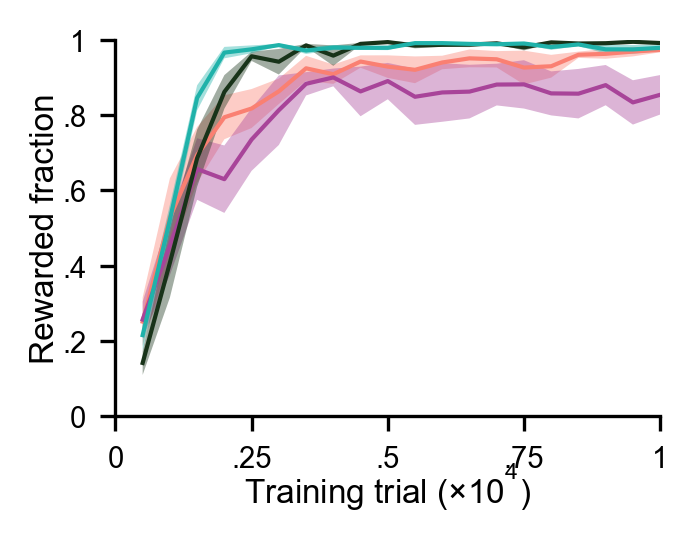

In [31]:
width = 2.2; height = 1.7

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 1, 6), 1)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
    ax.set_ylabel('Rewarded fraction', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.12)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xdata = perform_files[0][0].episode[perform_files[0][0].episode > 0].values
    for ymean, ysem, color, label in zip(mean_reward_frac, sem_reward_frac,
                                         [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c],
                                         ['Holistic actor+Holistic critic\n(Holistic agent)', 
                                          'Modular actor+Holistic critic', 
                                          'Holistic actor+Modular critic',
                                          'Modular actor+Modular critic\n(Modular agent)']):
        ax.plot(xdata, ymean, lw=lw, clip_on=True, c=color, label=label)
        ax.fill_between(xdata, ymean - ysem, ymean + ysem,
                        edgecolor='None', facecolor=color, alpha=0.4)
    
    fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='training_perform10'), orientation='portrait', format='pdf', transparent=True)

## 3c

In [32]:
mean_reward_rate = [np.vstack([file.reward_rate for file in perform_file]).mean(axis=0) 
                    for perform_file in perform_files]
sem_reward_rate = [sem(np.vstack([file.reward_rate for file in perform_file]), axis=0)
                   for perform_file in perform_files]

In [33]:
mean_reward_rate_holistic = [np.vstack([file.reward_rate 
                                                                for idx, file in enumerate(perform_file)]).mean(axis=0) 
                             for perform_file in perform_files_holistic] + [mean_reward_rate[-1]]
sem_reward_rate_holistic = [sem(np.vstack([file.reward_rate for file in perform_file]), axis=0)
                            for perform_file in perform_files_holistic] + [sem_reward_rate[-1]]

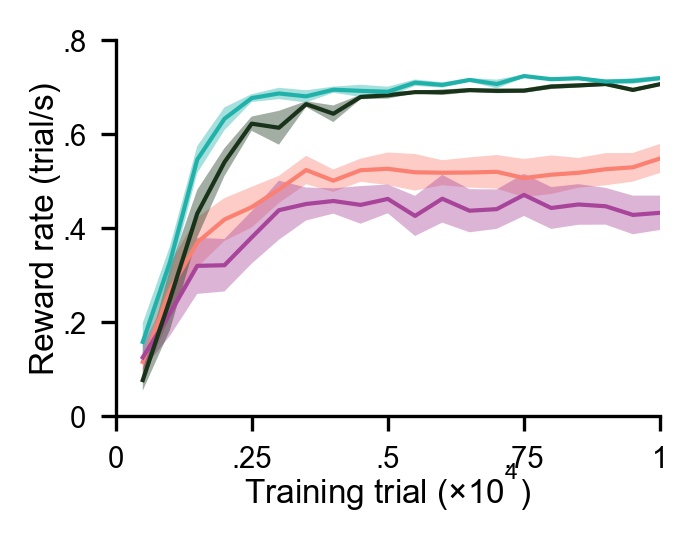

In [34]:
width = 2.2; height = 1.7

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.8, 5), 1)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
    ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.12)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xdata = perform_files[0][0].episode[perform_files[0][0].episode > 0].values
    for ymean, ysem, color, label in zip(mean_reward_rate, sem_reward_rate,
                                         [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c],
                                         ['Holistic actor+Holistic critic\n(Holistic agent)', 
                                          'Modular actor+Holistic critic', 
                                          'Holistic actor+Modular critic',
                                          'Modular actor+Modular critic\n(Modular agent)']):
        ax.plot(xdata, ymean, lw=lw, clip_on=True, c=color, label=label)
        ax.fill_between(xdata, ymean - ysem, ymean + ysem,
                        edgecolor='None', facecolor=color, alpha=0.4)
    
    fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='training_perform2'), orientation='portrait', format='pdf', transparent=True)

## S3f

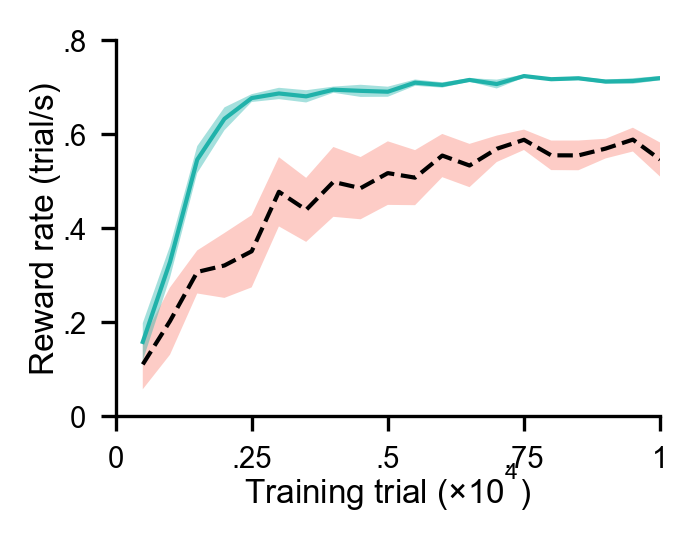

In [35]:
width = 2.2; height = 1.7

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.8, 5), 1)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
    ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.12)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xdata = perform_files[0][0].episode[perform_files[0][0].episode > 0].values
    for ymean, ysem, color, lc, ls in zip(mean_reward_rate_holistic, sem_reward_rate_holistic,
                                          [holistic_c, modular_c], 
                                          ['k', modular_c],
                                          ['--', '-']):
        ax.plot(xdata, ymean, lw=lw, ls=ls, clip_on=True, c=lc)
        ax.fill_between(xdata, ymean - ysem, ymean + ysem,
                        edgecolor='None', facecolor=color, alpha=0.4)
    
    fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='training_perform2_holistic'), orientation='portrait', format='pdf', transparent=True)

## 3d

In [36]:
mean_td_abs = [np.vstack([file.TD_error_abs for file in perform_file]).mean(axis=0)
               for perform_file in perform_files]
sem_td_abs = [sem(np.vstack([file.TD_error_abs for file in perform_file]), axis=0)
              for perform_file in perform_files]

In [37]:
mean_td_abs_holistic = [np.vstack([file.TD_error_abs for file in perform_file]).mean(axis=0)
                        for perform_file in perform_files_holistic] + [mean_td_abs[-1]]
sem_td_abs_holistic = [sem(np.vstack([file.TD_error_abs for file in perform_file]), axis=0)
                       for perform_file in perform_files_holistic] + [sem_td_abs[-1]]

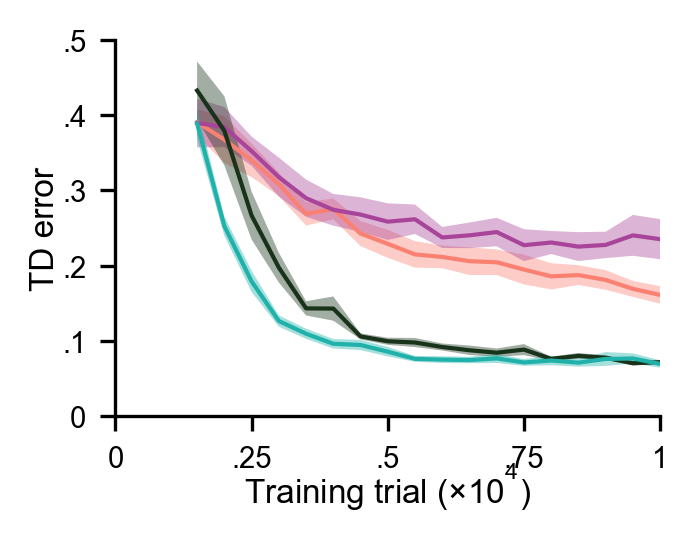

In [38]:
width = 2.2; height = 1.7

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.5, 6), 1)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
    ax.set_ylabel('TD error', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.12)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xdata = perform_files[0][0].episode[perform_files[0][0].episode > 0].values
    for (i, ymean), ysem, color, label in zip(enumerate(mean_td_abs), sem_td_abs,
                                              [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c],
                                              ['Holistic actor+Holistic critic\n(Holistic agent)', 
                                               'Modular actor+Holistic critic', 
                                               'Holistic actor+Modular critic',
                                               'Modular actor+Modular critic\n(Modular agent)']):
        start_idx = np.where(mean_reward_frac[i] > 0.6)[0][0]
        ax.plot(xdata[start_idx:], ymean[start_idx:], lw=lw, clip_on=True, c=color, label=label)
        ax.fill_between(xdata[start_idx:], (ymean - ysem)[start_idx:], (ymean + ysem)[start_idx:],
                        edgecolor='None', facecolor=color, alpha=0.4)
    
    fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='training_perform3'), orientation='portrait', format='pdf', transparent=True)

## S3g

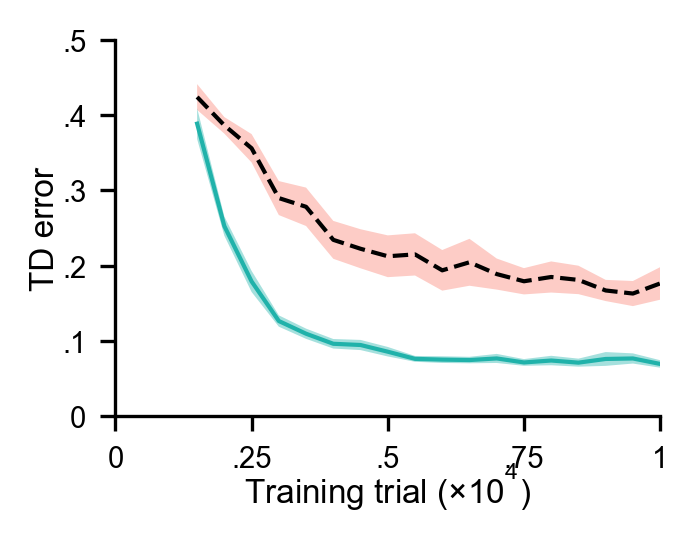

In [39]:
width = 2.2; height = 1.7

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.5, 6), 1)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
    ax.set_ylabel('TD error', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.12)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xdata = perform_files[0][0].episode[perform_files[0][0].episode > 0].values
    for (i, ymean), ysem, color, lc, ls in zip(enumerate(mean_td_abs_holistic), sem_td_abs_holistic,
                                               [holistic_c, modular_c],
                                               ['k', modular_c],
                                               ['--', '-']):
        ax.plot(xdata[start_idx:], ymean[start_idx:], lw=lw, ls=ls, clip_on=True, c=lc)
        ax.fill_between(xdata[start_idx:], (ymean - ysem)[start_idx:], (ymean + ysem)[start_idx:],
                        edgecolor='None', facecolor=color, alpha=0.4)
    
    fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='training_perform3_holistic'), orientation='portrait', format='pdf', transparent=True)

## 1g

925


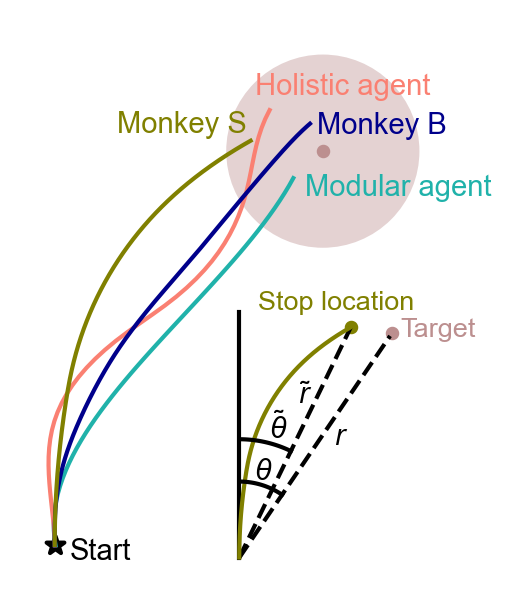

In [40]:
p_idx = 925
print(p_idx)

dfs = [modular_trajectories[7], holistic_trajectories[5], 
       bruno_normal_trajectory, schro_normal_trajectory]
modular_trial, holistic_trial, bruno_trial, schro_trial = [df.iloc[p_idx] for df in dfs]
    
with initiate_plot(1.8, 1.8, 300) as fig, warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
    
    # modular agent
    mx = modular_trial.pos_x; my = modular_trial.pos_y; mf = UnivariateSpline(my, mx)
    my_new = np.linspace(my[0], my[-1], endpoint=True)
    ax.plot(mf(my_new), my_new, lw=lw, c=modular_c)
    
    # holistic agent
    hx = holistic_trial.pos_x
    hy = holistic_trial.pos_y
    hf = UnivariateSpline(hy, hx)
    hy_new = np.linspace(hy[0], hy[-1], endpoint=True)
    ax.plot(hf(hy_new), hy_new, lw=lw, c=holistic_c)
    
    # monkey Bruno
    bx = bruno_trial.pos_x; by = bruno_trial.pos_y
    ax.plot(bx, by, lw=lw, c=monkB_c)
    
    # monkey Schro
    sx = schro_trial.pos_x; sy = schro_trial.pos_y
    ax.plot(sx, sy, lw=lw, c=monkS_c)
    
    # target position
    target_x = bruno_trial.target_x; target_y = bruno_trial.target_y
    cir1 = Circle(xy=[target_x, target_y], 
                  radius=arg.goal_radius_range[0] * arg.LINEAR_SCALE, 
                  alpha=0.4, color=reward_c, lw=0)
    ax.add_patch(cir1)
    ax.scatter(target_x, target_y, c=reward_c, s=5)
    
    # plot initial position
    ax.scatter(0, 0, c='k', s=20, marker='*')
    ax.text(10, -10, s='Start', fontsize=fontsize)
    ax.text(mx[-1] + 7, my[-1] - 12, s='Modular agent', fontsize=fontsize, c=modular_c)
    ax.text(hx[-1] - 10, hy[-1] + 10, s='Holistic agent', fontsize=fontsize, c=holistic_c)
    ax.text(bx[-1] + 5, by[-1] - 7, s='Monkey B', fontsize=fontsize, c=monkB_c)
    ax.text(sx[-1] - 90, sy[-1] + 5, s='Monkey S', fontsize=fontsize, c=monkS_c)

    
    # inset
    axins = ax.inset_axes([0.45, 0, 0.5, 0.5], zorder=-1)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_aspect('equal')
    axins.spines['top'].set_visible(False)
    axins.spines['right'].set_visible(False)
    axins.spines['bottom'].set_visible(False)
    axins.spines['left'].set_visible(False)
    
    # plot auxiliary lines
    axins.plot(np.linspace(0, 0), np.linspace(0, 290), c='k', ls='-', lw=1)
    axins.plot(np.linspace(0, sx[-1]), np.linspace(0, sy[-1]), c='k', ls='--', lw=1)
    k = target_y / target_x; x_ = np.linspace(0, target_x - 2.2)
    axins.plot(x_, k * x_, c='k', ls='--', lw=1)
    
    
    axins.plot(sx, sy, c=monkS_c, lw=lw)
    axins.scatter(sx[-1], sy[-1], c=monkS_c, s=5)
    # plot target position
    axins.scatter(target_x, target_y, c=reward_c, s=5)
    
    # plot angle symbols
    k_target = target_y / target_x
    r1 = 90
    intersect_x1 = np.sqrt(r1**2 / (1 + k_target**2))
    axins.plot(np.linspace(0, intersect_x1), 
            np.sqrt(r1**2 - np.linspace(0, intersect_x1)**2), c='k', lw=lw)
    
    k_stop = sy[-1] / sx[-1]
    r2 = 140
    intersect_x2 = np.sqrt(r2**2 / (1 + k_stop**2))
    axins.plot(np.linspace(0, intersect_x2),
            np.sqrt(r2**2 - np.linspace(0, intersect_x2)**2), c='k', lw=lw)
    
    
    axins.text(intersect_x1 / 2 - 8, r1 + 2, s=r'$\theta$', fontsize=fontsize)
    axins.text(intersect_x2 / 2 + 5, r2, s=r'$\tilde{\theta}$', fontsize=fontsize)
    axins.text(target_x / 2 + 22, target_y / 2, s=r'$r$', fontsize=fontsize)
    axins.text(sx[-1] / 2 + 4, sy[-1] / 2 + 45, s=r'$\tilde{r}$', fontsize=fontsize)
    axins.text(sx[-1] - 110, sy[-1] + 20, s="Stop location", fontsize=fontsize - 0.5, c=monkS_c)
    axins.text(target_x + 10, target_y - 5, s='Target', fontsize=fontsize - 0.5, c=reward_c)
        
    fig.tight_layout(pad=0)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='trial_example'), 
    #    orientation='portrait', format='pdf', transparent=True, bbox_inches='tight')

## 1h

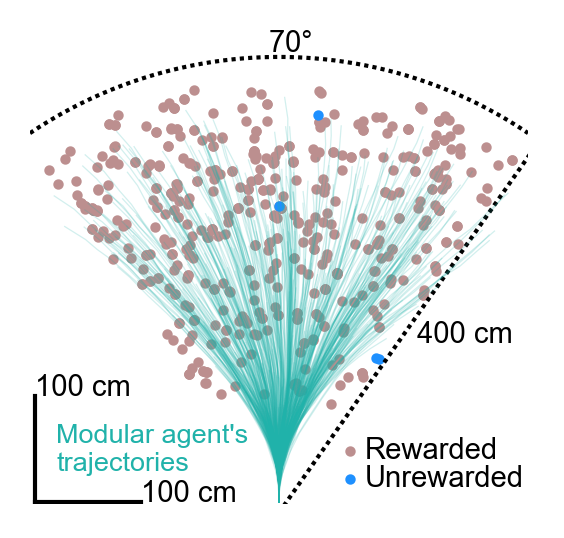

In [41]:
target_idexes = np.arange(0, 500)
df = modular_trajectories[3]
with initiate_plot(1.8, 1.8, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
    ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])
    
    ax.plot(np.linspace(0, 230 + 7), np.tan(np.deg2rad(55)) * np.linspace(0, 230 + 7) - 10, 
            c='k', ls=(0, (1, 1)), lw=lw)
    for _, trial in df.iloc[target_idexes].iterrows():
        ax.plot(trial.pos_x, trial.pos_y, c=modular_c, lw=0.3, ls='-', alpha=0.2)
        
    reward_idexes = df.rewarded.iloc[target_idexes].values
    for label, mask, c in zip(['Rewarded', 'Unrewarded'], [reward_idexes, ~reward_idexes], 
                              [reward_c, unreward_c]):
        ax.scatter(*df.iloc[target_idexes].loc[mask, ['target_x', 'target_y']].values.T, 
                   c=c, marker='o', s=1, lw=1.5, label=label)
    
    
    x_temp = np.linspace(-235, 235)
    ax.plot(x_temp, np.sqrt(420**2 - x_temp**2), c='k', ls=(0, (1, 1)), lw=lw)
    ax.text(-10, 425, s=r'70$\degree$', fontsize=fontsize)
    ax.text(130, 150, s=r'400 cm', fontsize=fontsize)
    
    ax.plot(np.linspace(-230, -130), np.linspace(0, 0), c='k', lw=lw)
    ax.plot(np.linspace(-230, -230), np.linspace(0, 100), c='k', lw=lw)
    ax.text(-230, 100, s=r'100 cm', fontsize=fontsize)
    ax.text(-130, 0, s=r'100 cm', fontsize=fontsize)
    
    ax.text(-210, 30, s="Modular agent's\ntrajectories", fontsize=fontsize - 0.5, c=modular_c)
    
    ax.legend(fontsize=fontsize, frameon=False, loc=[0.56, 0.0], 
              handletextpad=-0.5, labelspacing=0, ncol=1, columnspacing=1)

    fig.tight_layout(pad=0)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='Target_distribution'), orientation='landscape', format='pdf', transparent=True)

## S1c

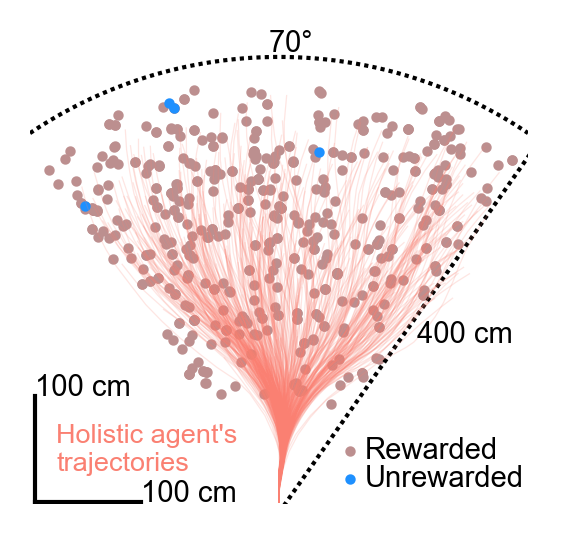

In [42]:
target_idexes = np.arange(0, 500)
df = holistic_trajectories[6]
with initiate_plot(1.8, 1.8, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
    ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])
    
    ax.plot(np.linspace(0, 230 + 7), np.tan(np.deg2rad(55)) * np.linspace(0, 230 + 7) - 10, 
            c='k', ls=(0, (1, 1)), lw=lw)
    for _, trial in df.iloc[target_idexes].iterrows():
        ax.plot(trial.pos_x, trial.pos_y, c=holistic_c, lw=0.3, ls='-', alpha=0.2)
        
    reward_idexes = df.rewarded.iloc[target_idexes].values
    for label, mask, c in zip(['Rewarded', 'Unrewarded'], [reward_idexes, ~reward_idexes], 
                              [reward_c, unreward_c]):
        ax.scatter(*df.iloc[target_idexes].loc[mask, ['target_x', 'target_y']].values.T, 
                   c=c, marker='o', s=1, lw=1.5, label=label)
    
    
    x_temp = np.linspace(-235, 235)
    ax.plot(x_temp, np.sqrt(420**2 - x_temp**2), c='k', ls=(0, (1, 1)), lw=lw)
    ax.text(-10, 425, s=r'70$\degree$', fontsize=fontsize)
    ax.text(130, 150, s=r'400 cm', fontsize=fontsize)
    
    ax.plot(np.linspace(-230, -130), np.linspace(0, 0), c='k', lw=lw)
    ax.plot(np.linspace(-230, -230), np.linspace(0, 100), c='k', lw=lw)
    ax.text(-230, 100, s=r'100 cm', fontsize=fontsize)
    ax.text(-130, 0, s=r'100 cm', fontsize=fontsize)
    
    ax.text(-210, 30, s="Holistic agent's\ntrajectories", fontsize=fontsize - 0.5, c=holistic_c)
    
    ax.legend(fontsize=fontsize, frameon=False, loc=[0.56, 0.0], 
              handletextpad=-0.5, labelspacing=0, ncol=1, columnspacing=1)

    fig.tight_layout(pad=0)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='sup_Target_distribution'), orientation='landscape', format='pdf', transparent=True)

## 1i

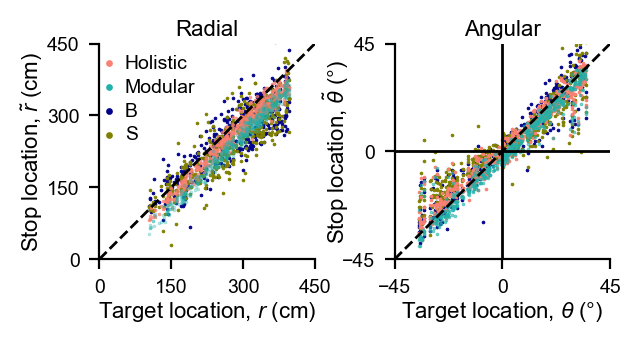

In [43]:
r_min = 0; r_max = 450; r_ticks = np.linspace(r_min, r_max, 4)
theta_bound = 45; theta_ticks = np.linspace(-theta_bound, theta_bound, 3)

width = 3; height = 1.7
scatter_size = 1
scatter_lw = 0.3
title_pad = 3

dfs = [bruno_normal_trajectory, schro_normal_trajectory, holistic_trajectory, modular_trajectory]
dfs = [df.iloc[:500] for df in dfs]
labels = ['B', 'S', 'Holistic', 'Modular']
colors = [monkB_c, monkS_c, holistic_c, modular_c]


with initiate_plot(width, height, 200) as fig:
    ax = fig.add_subplot(121)
    ax.set_aspect('equal')
    ax.set_title('Radial', fontsize=fontsize + 1, fontweight='normal', pad=title_pad)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(r_ticks, fontsize=fontsize)
    plt.yticks(r_ticks, fontsize=fontsize)
    ax.set_xlabel(r'Target location, $r$ (cm)', fontsize=fontsize + 1)
    ax.set_ylabel(r'Stop location, $\tilde{r}$ (cm)', fontsize=fontsize + 1)
    ax.set_xlim([r_min, r_max]); ax.set_ylim([r_min, r_max])
    ax.xaxis.set_label_coords(0.5, -0.18)
    ax.yaxis.set_label_coords(-0.25, 0.5)
    
    ax.plot(r_ticks, r_ticks, c='k', ls='--', lw=lw)
    
    alphas = [1, 1, 0.7, 0.3]
    dots = []
    for idx, df in enumerate(dfs):
        ax.scatter(*list(df.loc[:, ['target_r', 'pos_r_end']].values.T),
                   marker='o', s=scatter_size, alpha=alphas[idx], 
                   c=colors[idx], lw=scatter_lw)
        dots.append(ax.scatter([], [], marker='o', s=2, c=colors[idx]))
    
    ax.legend(dots[2:] + dots[:2], labels[2:] + labels[:2], fontsize=fontsize, 
              frameon=False, loc=[-0.08, 0.5], handletextpad=-0.2, labelspacing=0.3)
    
    ax = fig.add_subplot(122)
    ax.set_aspect('equal')
    ax.set_title('Angular', fontsize=fontsize + 1, fontweight='normal', pad=title_pad)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(theta_ticks, fontsize=fontsize)
    plt.yticks(theta_ticks, fontsize=fontsize)
    ax.set_xlabel(r'Target location, $\theta$ ($\degree$)', fontsize=fontsize + 1)
    ax.set_ylabel(r'Stop location, $\tilde{\theta}$ ($\degree$)', fontsize=fontsize + 1)
    ax.set_xlim([-theta_bound, theta_bound]); ax.set_ylim([-theta_bound, theta_bound])
    ax.xaxis.set_label_coords(0.5, -0.18)
    ax.yaxis.set_label_coords(-0.2, 0.5)
    
    ax.plot(theta_ticks, np.linspace(0, 0, 3), c='k', lw=lw)
    ax.plot(np.linspace(0, 0, 3), theta_ticks, c='k', lw=lw)
    ax.plot(theta_ticks, theta_ticks, c='k', ls='--', lw=lw)
    
    alphas = [1, 1, 1, 0.6]
    for idx, df in enumerate(dfs):
        ax.scatter(*list(df.loc[:, ['target_theta', 'pos_theta_end']].values.T - 90),
                   marker='o', s=scatter_size, alpha=alphas[idx], 
                   c=colors[idx], lw=scatter_lw)
    
    fig.tight_layout(pad=0, w_pad=-0.3)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='response_vs_target'), orientation='portrait', format='pdf', transparent=True)

## S1d-e

In [44]:
dfs = [holistic_trajectory, moho_trajectory, homo_trajectory, modular_trajectory,
       bruno_normal_trajectory, schro_normal_trajectory]

models = []
rs = []
coefs = []
for i, df in enumerate(dfs):
    model_r = LinearRegression(fit_intercept=False)
    X = df.target_r.values.reshape(-1, 1)
    y = df.pos_r_end.values
    model_r.fit(X, y)
    models.append(model_r)
    rs.append(np.corrcoef(model_r.predict(X), y)[0, 1])
    coefs.append(model_r.coef_[0])
    
    model_theta = LinearRegression(fit_intercept=False)
    X = df.target_theta.values.reshape(-1, 1) - 90
    y = df.pos_theta_end.values - 90
    model_theta.fit(X, y)
    models.append(model_theta)
    rs.append(np.corrcoef(model_theta.predict(X), y)[0, 1])
    coefs.append(model_theta.coef_[0])

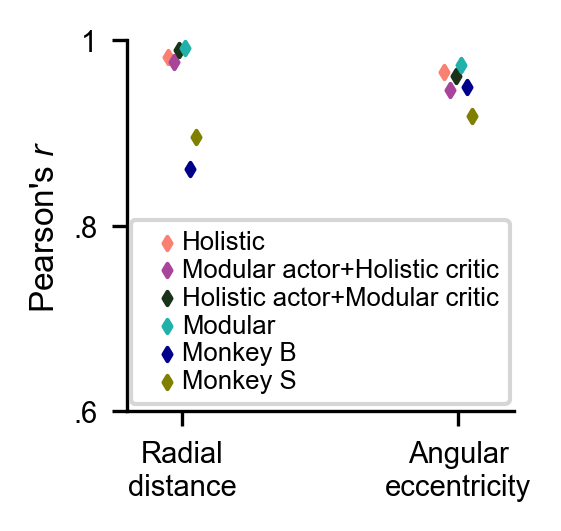

In [45]:
# slope of linear regression
width = 1.7
height = 1.6

x_labels = ['Radial\ndistance', 'Angular\neccentricity']
x_ticks = np.linspace(0, 1, 2)
y_ticks = np.linspace(0.6, 1, 3)
labels = ['Holistic', 'Modular actor+Holistic critic', 'Holistic actor+Modular critic', 
          'Modular', 'Monkey B', 'Monkey S']
colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, monkB_c, monkS_c]
shifts = np.linspace(-0.05, 0.05, len(labels))

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(x_ticks, x_labels, fontsize=fontsize)
    plt.yticks(y_ticks, fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize + 1)
    ax.set_ylabel("Pearson's $r$", fontsize=fontsize + 1)
    ax.set_xlim([-0.2, 1.2]); ax.set_ylim([y_ticks[0], y_ticks[-1]])
    ax.yaxis.set_label_coords(-0.17, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    
    for variable in range(2):
        for (idx, color), shift in zip(enumerate(colors), shifts):
            ax.scatter(variable + shift, rs[variable::2][idx], color=color, s=5, 
                       label=labels[idx] if variable == 0 else None, clip_on=False, marker='d')
            
    ax.legend(fontsize=fontsize - 0.8, frameon=True, 
              loc=[0.01, 0.02], handletextpad=-0.4, labelspacing=0.15, ncol=1, columnspacing=0)

    fig.tight_layout(pad=0.1, w_pad=0, h_pad=0)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='sup_response_vs_target1'), orientation='portrait', format='pdf', transparent=True)

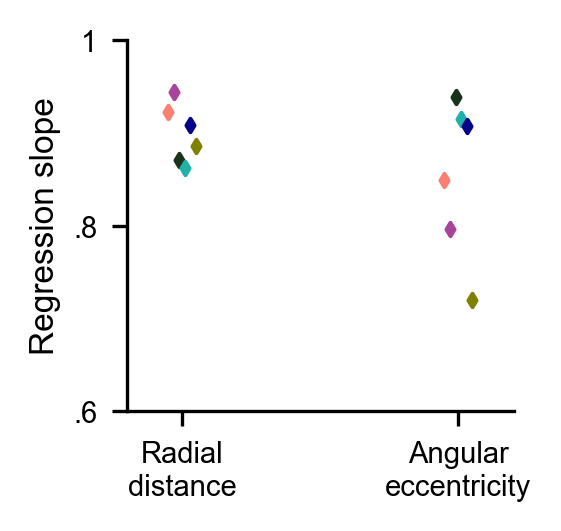

In [46]:
# slope of linear regression
width = 1.7
height = 1.6

x_labels = ['Radial\ndistance', 'Angular\neccentricity']
x_ticks = np.linspace(0, 1, 2)
y_ticks = np.linspace(0.6, 1, 3)
labels = ['Holistic', 'Modular actor+Holistic critic', 'Holistic actor+Modular critic', 
          'Modular', 'Monkey B', 'Monkey S']
colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, monkB_c, monkS_c]
shifts = np.linspace(-0.05, 0.05, len(labels))

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(x_ticks, x_labels, fontsize=fontsize)
    plt.yticks(y_ticks, fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize + 1)
    ax.set_ylabel('Regression slope', fontsize=fontsize + 1)
    ax.set_xlim([-0.2, 1.2]); ax.set_ylim([y_ticks[0], y_ticks[-1]])
    ax.yaxis.set_label_coords(-0.17, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    for variable in range(2):
        for (idx, color), shift in zip(enumerate(colors), shifts):
            ax.scatter(variable + shift, coefs[variable::2][idx], color=color, s=5, marker='d')

    fig.tight_layout(pad=0.1, w_pad=2, h_pad=0, rect=[0.005, 0, 1.005, 1])
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='sup_response_vs_target2'), orientation='portrait', format='pdf', transparent=True)

## 1j

In [47]:
dfs = [holistic_trajectories, moho_trajectories, homo_trajectories, modular_trajectories,
       [bruno_normal_trajectory], [schro_normal_trajectory], [bruno_normal_trajectory]]

In [48]:
max_reward_boundary = 400
hypo_reward_boundaries = np.arange(max_reward_boundary)

targets1 = bruno_normal_trajectory[['target_x', 'target_y']].values
targets2 = schro_normal_trajectory[['target_x', 'target_y']].values
shuffled_targets1 = targets1.copy(); shuffled_targets2 = targets2.copy()
rng = default_rng(1); rng.shuffle(shuffled_targets1, axis=0); rng.shuffle(shuffled_targets2, axis=0)

ydata_subjects = []; xdata_subjects = []
for idx, dfs_ in enumerate(dfs):
    targets, shuffled_targets = (targets2, shuffled_targets2) if idx == 5 else (targets1, shuffled_targets1)
    ydata_ = []; xdata_ = []
    for df in dfs_:
        ydata = []; xdata = []
        for reward_boundary in hypo_reward_boundaries:
            if idx != 6:
                ydata.append((np.linalg.norm(np.vstack([[i[-1] for i in df.pos_x], [i[-1] for i in df.pos_y]]).T 
                                             - targets, axis=1) 
                              < reward_boundary).sum() / len(df))
            else:
                ydata.append((np.ones_like(targets[:, 0]) * (arg.goal_radius_range[0] * arg.LINEAR_SCALE) 
                              < reward_boundary).sum() / len(df))
            xdata.append((np.linalg.norm(np.vstack([[i[-1] for i in df.pos_x], [i[-1] for i in df.pos_y]]).T
                                         - shuffled_targets, axis=1) 
                          < reward_boundary).sum() / len(df))
                
        ydata_.append(ydata); xdata_.append(xdata)
    ydata_subjects.append(ydata_); xdata_subjects.append(xdata_)

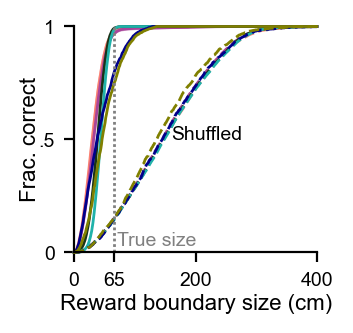

In [49]:
reward_boundary = int(arg.goal_radius_range[0] * arg.LINEAR_SCALE)
xticks = [0, reward_boundary, 200, 400]
yticks = np.linspace(0, 1, 3)

width = 1.6; height = 1.5

colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, monkB_c, monkS_c]

with initiate_plot(width, height, 200) as fig:
    ax = fig.add_subplot(111)
    #ax.set_title('Psychometric function', fontsize=fontsize + 1, pad=5)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel('Reward boundary size (cm)', fontsize=fontsize + 1)
    ax.set_ylabel('Frac. correct', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0], xticks[-1]]); ax.set_ylim([yticks[0], yticks[-1]])
    ax.xaxis.set_label_coords(0.5, -0.18)
    ax.yaxis.set_label_coords(-0.14, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    for xdata, ydata, c in zip(xdata_subjects, ydata_subjects, colors):
        xmean = np.vstack(xdata).mean(axis=0)
        ymean = np.vstack(ydata).mean(axis=0)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            yerror = sem(np.vstack(ydata), axis=0)
        
        ax.plot(np.arange(len(xmean[:max_reward_boundary])), 
                xmean[:max_reward_boundary], c=c, lw=lw, ls='--', clip_on=False)
        ax.plot(np.arange(len(ymean[:max_reward_boundary])), 
                ymean[:max_reward_boundary], c=c, lw=lw, clip_on=False)
        ax.fill_between(np.arange(len(ymean[:max_reward_boundary])), ymean - yerror, ymean + yerror,
                        edgecolor='None', facecolor=c, alpha=0.5)
    
    ax.plot(np.linspace(reward_boundary, reward_boundary), np.linspace(*ax.get_ylim()), 
            lw=lw, ls=(0, (1, 1)), c='gray')
    ax.text(70, 0.03, 'True size', fontsize=fontsize, c='gray')
    
    ax.text(160, 0.5, 'Shuffled', fontsize=fontsize)

    
    fig.tight_layout(pad=0.1, w_pad=-0.3)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='sup_roc1'), orientation='portrait', format='pdf', transparent=True)

## 1k

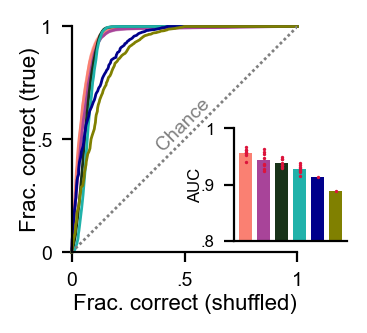

In [50]:
ticks = np.linspace(0, 1, 3)

width = 1.85; height = 1.5

colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, monkB_c, monkS_c]

with initiate_plot(width, height, 200) as fig:
    ax = fig.add_subplot(111)    
    ax.set_aspect('equal')
    #ax.set_title('Performance', fontsize=fontsize + 1, pad=5)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(ticks, fontsize=fontsize)
    plt.yticks(ticks, fontsize=fontsize)
    ax.set_xlabel('Frac. correct (shuffled)', fontsize=fontsize + 1)
    ax.set_ylabel('Frac. correct (true)', fontsize=fontsize + 1)
    ax.set_xlim([ticks[0], ticks[-1]]); ax.set_ylim(ax.get_xlim())
    ax.xaxis.set_label_coords(0.5, -0.18)
    ax.yaxis.set_label_coords(-0.14, 0.5)
    ax.xaxis.set_major_formatter(major_formatter)
    ax.yaxis.set_major_formatter(major_formatter)

    rocs = []
    for xdata, ydata, c in zip(xdata_subjects, ydata_subjects, colors):
        xmean = np.vstack(xdata).mean(axis=0)
        ymean = np.vstack(ydata).mean(axis=0)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            yerror = sem(np.vstack(ydata), axis=0)
        
        ax.plot(xmean, ymean, c=c, lw=lw, clip_on=False, label=label)
        ax.fill_between(xmean, ymean - yerror, ymean + yerror,
                        edgecolor='None', facecolor=c, alpha=0.5)
        rocs.append([np.trapz(y, z) for y, z in zip(ydata, xdata)])
        
    ax.plot(np.linspace(0, 1), np.linspace(0, 1), lw=lw, c='gray', ls=(0, (1, 1)))
    ax.text(0.36, 0.45, 'Chance', fontsize=fontsize, rotation=45, c='gray')
    
    axins = ax.inset_axes([0.72, 0.05, 0.5, 0.5], zorder=-1)
    axins.spines['top'].set_visible(False); axins.spines['right'].set_visible(False)
    axins.set_xticks([]); axins.set_xticklabels('')
    axins.set_yticks([0.8, 0.9, 1])
    axins.set_yticklabels([0.8, 0.9, 1], fontsize=fontsize - 1)
    axins.set_xlabel('', fontsize=fontsize - 1)
    axins.set_ylabel('AUC', fontsize=fontsize - 1)
    axins.set_ylim(0.8, 1)
    axins.yaxis.set_label_coords(-0.28, 0.5)
    axins.yaxis.set_major_formatter(major_formatter)
    
    for idx, roc in enumerate(rocs):
        axins.bar(idx, np.mean(roc), width=0.7, color=colors[idx], alpha=1, zorder=0)
        axins.scatter([idx] * len(roc), roc, c='crimson', 
                      marker='.', s=2, lw=0.5, zorder=1)
    
    fig.tight_layout(pad=0.1, rect=(0.01, 0, 1.01, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='sup_roc2'), orientation='portrait', format='pdf', transparent=True)

## 1l

In [51]:
def get_neural_response(agent, df, layer='rnn'):
    model = agent.actor
    responses = []

    df = pd.DataFrame([df]) if isinstance(df, pd.Series) else df
    with torch.no_grad():
        for _, trial in df.iterrows():
            response, _ = model.rnn(trial.state)
            if layer != 'rnn':
                response = F.relu(model.l2(F.relu(model.l1(response))))
            responses.append(response)
        
    return torch.cat(responses).squeeze(1).numpy()

In [52]:
def fit_decoder(agent, trajectory, layer, get_neural_response,
                variables=['pos_v', 'pos_w', 'relative_radius', 'relative_angle', 'action_v', 'action_w'],
                train_frac=0.7):
    train_trajectory = trajectory[:round(len(trajectory) * train_frac)]
    train_X = get_neural_response(agent, train_trajectory, layer=layer)
    test_trajectory = trajectory[round(len(trajectory) * train_frac):]
    test_X = get_neural_response(agent, test_trajectory, layer=layer)
    
    y = train_trajectory[variables].values
    train_y = np.vstack([np.hstack(y[:, i]) for i in range(y.shape[1])]).T
    y = test_trajectory[variables].values
    test_y = np.vstack([np.hstack(y[:, i]) for i in range(y.shape[1])]).T
    
    decoder = RidgeCV()
    decoder.fit(train_X, train_y)
    
    return decoder, test_X, test_y

In [53]:
holistic_decoder, modular_decoder_rnn, modular_decoder_mlp = map(fit_decoder, 
                                    [holistic_agent, modular_agent, modular_agent], 
                                    [holistic_trajectory, modular_trajectory, modular_trajectory], 
                                    ['rnn', 'rnn', 'mlp'], [get_neural_response] * 3)

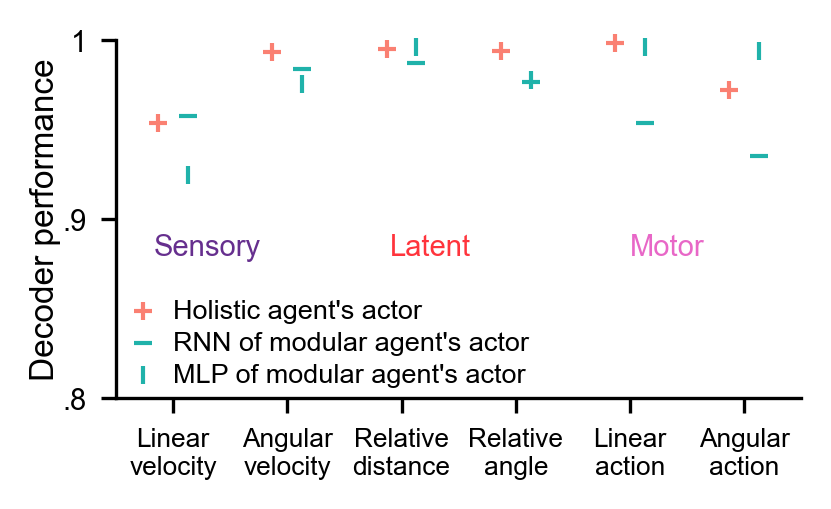

In [54]:
width = 2.6
height = 1.55
scatter_size = 20
scatter_lw = 1

x_labels = ['Linear\nvelocity', 'Angular\nvelocity', 'Relative\ndistance', 'Relative\nangle',
            'Linear\naction', 'Angular\naction']
x_ticks = np.arange(0, len(x_labels), 1)
y_ticks = np.linspace(0.8, 1, 3)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(x_ticks, x_labels, fontsize=fontsize - 0.7)
    plt.yticks(y_ticks, fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('Decoder performance', fontsize=fontsize + 1)
    ax.set_xlim([x_ticks[0] - 0.5, x_ticks[-1] + 0.5]); ax.set_ylim([0.8, 1])
    ax.yaxis.set_major_formatter(major_formatter)
    ax.yaxis.set_label_coords(-0.08, 0.5)
    
    for decoder, marker, label, x_shift, color in zip([holistic_decoder, modular_decoder_rnn, modular_decoder_mlp], 
                                                      ['+', '_', '|'], 
                                                      ["Holistic agent's actor", 
                                                       "RNN of modular agent's actor", 
                                                       "MLP of modular agent's actor"],
                                                      [-0.13, 0.13, 0.13], [holistic_c, modular_c, modular_c]):
        ax.scatter([], [], s=scatter_size, lw=lw, color=color, marker=marker, label=label)
        for idx in range(len(x_labels)):
            corr = np.corrcoef(decoder[2][:, idx], decoder[0].predict(decoder[1])[:, idx])[0, 1]
            ax.scatter(idx + x_shift, corr, s=scatter_size, lw=lw, color=color, marker=marker, clip_on=False)
    
    ax.text(-0.17, 0.88, s=r'Sensory', c=sensory_c, fontsize=fontsize)
    ax.text(1.9, 0.88, s='Latent', c=belief_c, fontsize=fontsize)
    ax.text(4, 0.88, s='Motor', c=motor_c, fontsize=fontsize)
    
    ax.legend(fontsize=fontsize-0.5, frameon=False, loc=[-0.015, 0], 
              handletextpad=0.1, labelspacing=0.3, ncol=1, columnspacing=1)

    fig.tight_layout(pad=0.18)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='decoder'), orientation='portrait', format='pdf', transparent=True)

## s1f

In [55]:
def get_neural_response_critic(agent, df, layer='rnn'):
    model = agent.critic
    responses = []

    df = pd.DataFrame([df]) if isinstance(df, pd.Series) else df
    with torch.no_grad():
        for _, trial in df.iterrows():
            if model.rnn1.hidden_size == 220:
                response, _ = model.rnn1(torch.cat([trial.state, trial.action], dim=-1))
            else:
                response, _ = model.rnn1(trial.state)
            if layer != 'rnn':
                response = F.relu(model.l2(F.relu(model.l1(torch.cat([response, trial.action], dim=-1)))))
            responses.append(response)
        
    return torch.cat(responses).squeeze(1).numpy()

In [56]:
holistic_decoder, modular_decoder_rnn, modular_decoder_mlp = map(fit_decoder, 
                                    [holistic_agent, modular_agent, modular_agent], 
                                    [holistic_trajectory, modular_trajectory, modular_trajectory], 
                                    ['rnn', 'rnn', 'mlp'], [get_neural_response_critic] * 3,
                                    [['pos_v', 'pos_w', 'relative_radius', 'relative_angle'] for _ in range(3)])

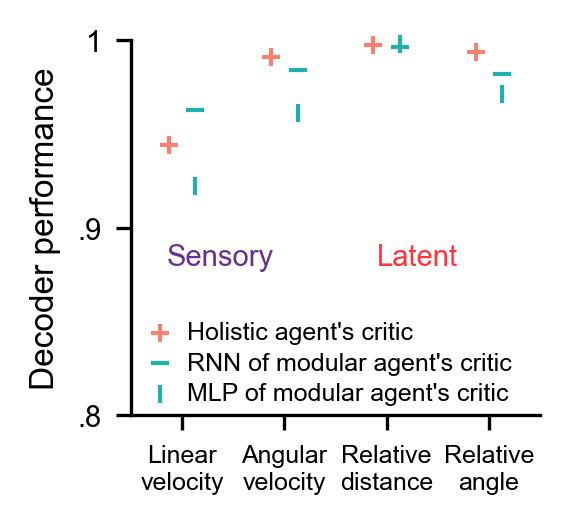

In [57]:
width = 1.7
height = 1.55
scatter_size = 20
scatter_lw = 1

x_labels = ['Linear\nvelocity', 'Angular\nvelocity', 'Relative\ndistance', 'Relative\nangle']
x_ticks = np.arange(0, len(x_labels), 1)
y_ticks = np.linspace(0.8, 1, 3)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(x_ticks, x_labels, fontsize=fontsize - 1)
    plt.yticks(y_ticks, fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize + 1)
    ax.set_ylabel('Decoder performance', fontsize=fontsize + 1)
    ax.set_xlim([x_ticks[0] - 0.5, x_ticks[-1] + 0.5]); ax.set_ylim([0.8, 1])
    ax.yaxis.set_major_formatter(major_formatter)
    
    for decoder, marker, label, x_shift, color in zip([holistic_decoder, modular_decoder_rnn, modular_decoder_mlp], 
                                                      ['+', '_', '|'], 
                                                      ["Holistic agent's critic", 
                                                       "RNN of modular agent's critic", 
                                                       "MLP of modular agent's critic"],
                                                      [-0.13, 0.13, 0.13], [holistic_c, modular_c, modular_c]):
        ax.scatter([], [], s=scatter_size, lw=lw, color=color, marker=marker, label=label)
        for idx in range(len(x_labels)):
            corr = np.corrcoef(decoder[2][:, idx], decoder[0].predict(decoder[1])[:, idx])[0, 1]
            ax.scatter(idx + x_shift, corr, s=scatter_size, lw=lw, color=color, marker=marker, clip_on=False)
    
    ax.text(-0.15, 0.88, s=r'Sensory', c=sensory_c, fontsize=fontsize)
    ax.text(1.9, 0.88, s='Latent', c=belief_c, fontsize=fontsize)
    
    ax.legend(fontsize=fontsize - 1, frameon=False, loc=[-0.015, 0], 
              handletextpad=0.1, labelspacing=0.3, ncol=1, columnspacing=1)

    fig.tight_layout(pad=0)
    
    #plt.savefig(figure_path / 'paper_figures/raw/{name}.pdf'.format(
    #    name='sup_decoder'), orientation='portrait', format='pdf', transparent=True)

## 3a

In [58]:
def compute_curvature(dfs, stack_trials=True):
    arg = config.ConfigCore()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        dfs = [dfs] if not isinstance(dfs, list) else dfs
        curvs = []
        for df in dfs:
            if 'gain_v' not in df.columns:
                linear_scale = 1
                df_ = df
                x_key = 'pos_x'; y_key = 'pos_y'
            else:
                if (df.gain_v > 100).any():  # monkey df
                    linear_scale = arg.LINEAR_SCALE
                    df_ = downsample(df)
                    x_key = 'pos_x_ds'; y_key = 'pos_y_ds'
                else:
                    linear_scale = 1
                    df_ = df
                    x_key = 'pos_x'; y_key = 'pos_y'

            curv = []
            for _, trial in df_.iterrows():
                dx = np.gradient(trial[x_key] * linear_scale); ddx = np.gradient(dx)
                dy = np.gradient(trial[y_key] * linear_scale); ddy = np.gradient(dy)
                curv_ = abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**(3 / 2)
                curv_ = curv_[(~np.isnan(curv_))]
                if curv_.size > 0:
                    curv_ = curv_[curv_ < np.percentile(curv_, 95)]
                else:
                    curv_ = np.array([np.nan])
                curv.append(curv_)

            curvs.append(np.hstack(curv)) if stack_trials else curvs.append(curv)
    return curvs

In [59]:
curvatures_holistic = [compute_curvature(holistic_trajectories[seed_idx], stack_trials=False) 
                       for seed_idx in range(len(holistic_trajectories))]
curvatures_moho = [compute_curvature(moho_trajectories[seed_idx], stack_trials=False) 
                   for seed_idx in range(len(moho_trajectories))]
curvatures_homo = [compute_curvature(homo_trajectories[seed_idx], stack_trials=False) 
                   for seed_idx in range(len(homo_trajectories))]
curvatures_modular = [compute_curvature(modular_trajectories[seed_idx], stack_trials=False) 
                      for seed_idx in range(len(modular_trajectories))]

curvature_bruno = compute_curvature(bruno_normal_trajectory, stack_trials=False)[0]
curvature_schro = compute_curvature(schro_normal_trajectory, stack_trials=False)[0]

In [60]:
curvatures_holisticControlEKF = [compute_curvature(holistic_controlEKF_trajectories[seed_idx], stack_trials=False) 
                                 for seed_idx in range(len(holistic_controlEKF_trajectories))]

In [61]:
def get_curv_diff(agent_data, monkey_data=curvature_bruno):
    mask1 = bruno_normal_trajectory.rewarded & schro_normal_trajectory.rewarded
    mean_curv_monkey = np.array([(trial).mean() for trial in monkey_data])[mask1]
    curv_diff = []
    for agent_data_ in agent_data: # loop seeds
        mean_curv_agent = np.array([(trial).mean() for trial in agent_data_[0]])[mask1]
        mask2 = ~np.isnan(mean_curv_agent)
        curv_diff.append(abs(mean_curv_agent - mean_curv_monkey)[mask2])
        
    return np.hstack(curv_diff)

In [62]:
ydata = list(map(get_curv_diff, [curvatures_holistic, curvatures_moho, curvatures_homo, curvatures_modular, 
                                 [[curvature_schro]]]))

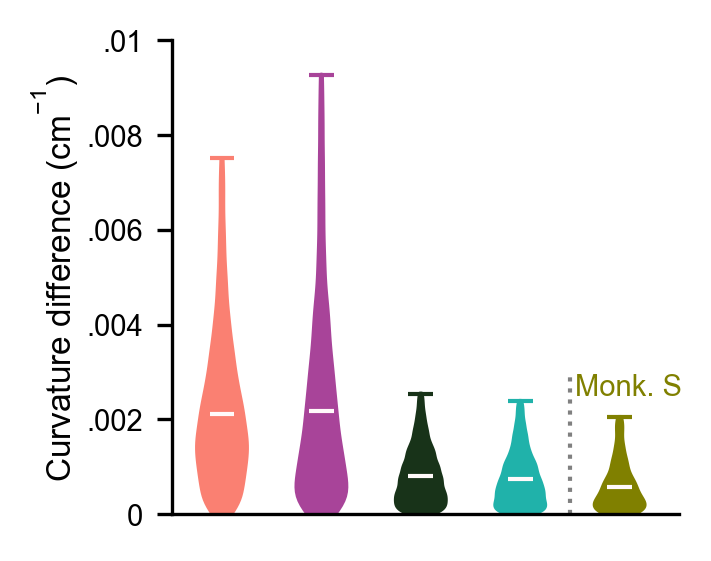

In [63]:
width = 2.2
height = 1.7
violin_width = 0.5

xticks = np.arange(5)
yticks = np.linspace(0, 0.01, 6)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel(r'Curvature difference (cm$^{-1}$)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - violin_width, xticks[-1] + 1.2 * violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.yaxis.set_label_coords(-0.18, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    
    colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, monkS_c]
    for (idx, curv), color in zip(enumerate(ydata), colors):
        locals()[f'vp{idx}'] = ax.violinplot(filter_fliers(curv), 
                                             positions=[idx], widths=violin_width, showmeans=True)
        set_violin_plot(locals()[f'vp{idx}'], facecolor=color, edgecolor=color)
        
    plt.xticks([], fontsize=fontsize)
    ax.plot(np.linspace(3.5, 3.5), np.linspace(0, 0.003), c='gray', ls=':', lw=lw) 
    ax.text(3.55, 0.0025, 'Monk. S', fontsize=fontsize, c=monkS_c)
    
    plt.tight_layout(pad=0.1)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='curvature_diff'), orientation='portrait', format='pdf', transparent=True)

## S3a

In [64]:
def get_curv(agent_data):
    mask1 = bruno_normal_trajectory.rewarded & schro_normal_trajectory.rewarded
    curv = []
    for agent_data_ in agent_data: # loop seeds
        mean_curv_agent = np.array([(trial).mean() for trial in agent_data_[0]])[mask1]
        curv.append(mean_curv_agent[~np.isnan(mean_curv_agent)])     
    return np.hstack(curv)

ydata = list(map(get_curv, [curvatures_holistic, curvatures_moho, curvatures_homo, curvatures_modular]))
ydata_holistic = list(map(get_curv, [curvatures_holisticControlEKF, curvatures_modular]))

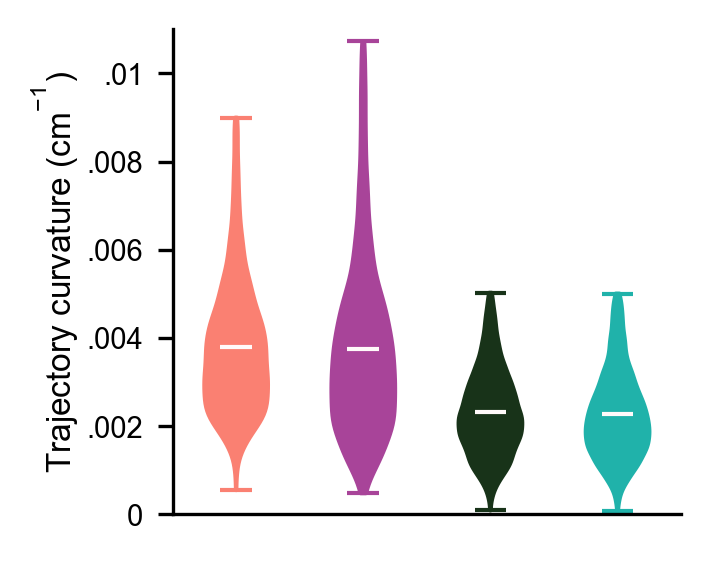

In [65]:
width = 2.2
height = 1.7
violin_width = 0.5

xticks = np.arange(4)
yticks = np.linspace(0, 0.01, 6)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel(r'Trajectory curvature (cm$^{-1}$)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - violin_width, xticks[-1] + violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]+0.001])
    ax.yaxis.set_label_coords(-0.18, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    
    colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
    for (idx, curv), color in zip(enumerate(ydata), colors):
        locals()[f'vp{idx}'] = ax.violinplot(filter_fliers(curv), 
                                             positions=[idx], widths=violin_width, showmeans=True)
        set_violin_plot(locals()[f'vp{idx}'], facecolor=color, edgecolor=color)
        
    plt.xticks([], fontsize=fontsize)
    
    plt.tight_layout(pad=0.1, rect=(0.01, 0, 1.01, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='sup_curvature'), orientation='portrait', format='pdf', transparent=True)

## S3d

In [66]:
def set_violin_plot(vp, facecolor, edgecolor, linewidth=1, alpha=1, ls='-', hatch=r''):
    plt.setp(vp['bodies'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha ,ls=ls, hatch=hatch)
    plt.setp(vp['cmins'], facecolor=facecolor, edgecolor=facecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cmaxes'], facecolor=facecolor, edgecolor=facecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cbars'], facecolor='None', edgecolor='None', 
             linewidth=linewidth, alpha=alpha)
    
    linecolor = 'k' if facecolor == 'None' else 'snow'
    if 'cmedians' in vp:
        plt.setp(vp['cmedians'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)
    if 'cmeans' in vp:
        plt.setp(vp['cmeans'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)

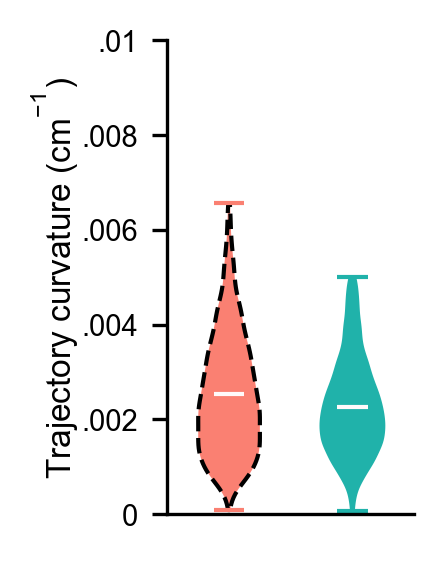

In [67]:
width = 1.4
height = 1.7
violin_width = 0.5

xticks = np.arange(2)
yticks = np.linspace(0, 0.01, 6)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel(r'Trajectory curvature (cm$^{-1}$)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - violin_width, xticks[-1] + violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.yaxis.set_label_coords(-0.35, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    
    colors = [holistic_c, modular_c]
    ecs = ['k', modular_c]
    lss = ['--', '-']
    for (idx, curv), color, ls, ec in zip(enumerate(ydata_holistic), colors, lss, ecs):
        locals()[f'vp{idx}'] = ax.violinplot(filter_fliers(curv), 
                                             positions=[idx], widths=violin_width, showmeans=True)
        set_violin_plot(locals()[f'vp{idx}'], facecolor=color, edgecolor=ec, ls=ls)
        
    plt.xticks([], fontsize=fontsize)
    
    plt.tight_layout(pad=0.1, rect=(0.01, 0, 1.01, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='curvature_diff_holistic'), orientation='portrait', format='pdf', transparent=True)

## 3b

In [68]:
def compute_length(dfs):
    arg = config.ConfigCore()
    dfs = [dfs] if not isinstance(dfs, list) else dfs
    lengths = []
    for df in dfs:
        if 'gain_v' not in df.columns:
            linear_scale = 1
            df_ = df
            x_key = 'pos_x'; y_key = 'pos_y'
        else:
            if (df.gain_v > 100).any():  # monkey df
                linear_scale = arg.LINEAR_SCALE
                df_ = downsample(df)
                x_key = 'pos_x_ds'; y_key = 'pos_y_ds'
            else:
                linear_scale = 1
                df_ = df
                x_key = 'pos_x'; y_key = 'pos_y'

        length = []
        for _, trial in df_.iterrows():
            dx = np.diff(trial[x_key] * linear_scale)
            dy = np.diff(trial[y_key] * linear_scale)
            length.append((np.sqrt(dx**2 + dy**2)).sum())
        lengths.append(np.hstack(length))
    return lengths

In [69]:
lengths_holistic = [compute_length(holistic_trajectories[seed_idx]) for seed_idx in range(len(holistic_trajectories))]
lengths_moho = [compute_length(moho_trajectories[seed_idx]) for seed_idx in range(len(moho_trajectories))]
lengths_homo = [compute_length(homo_trajectories[seed_idx]) for seed_idx in range(len(homo_trajectories))]
lengths_modular = [compute_length(modular_trajectories[seed_idx]) for seed_idx in range(len(modular_trajectories))]

length_bruno = compute_length(bruno_normal_trajectory)[0]
length_schro = compute_length(schro_normal_trajectory)[0]

In [70]:
lengths_holisticControlEKF = [compute_length(holistic_controlEKF_trajectories[seed_idx]) 
                              for seed_idx in range(len(holistic_controlEKF_trajectories))]

In [71]:
def get_length_diff(agent_data, monkey_data=length_bruno, mask=bruno_normal_trajectory.rewarded):
    mask = bruno_normal_trajectory.rewarded & schro_normal_trajectory.rewarded
    length_diff = []
    if len(agent_data) > 1:
        for agent_data_ in agent_data: # loop seeds
            length_agent = agent_data_[0]
            length_diff.append(abs(length_agent - monkey_data)[mask])
    else:
        length_diff.append(abs(agent_data[0][0] - monkey_data)[mask])
        
    return np.hstack(length_diff)

In [72]:
ydata = list(map(get_length_diff, [lengths_holistic, lengths_moho, lengths_homo, lengths_modular, [[length_schro]]]))

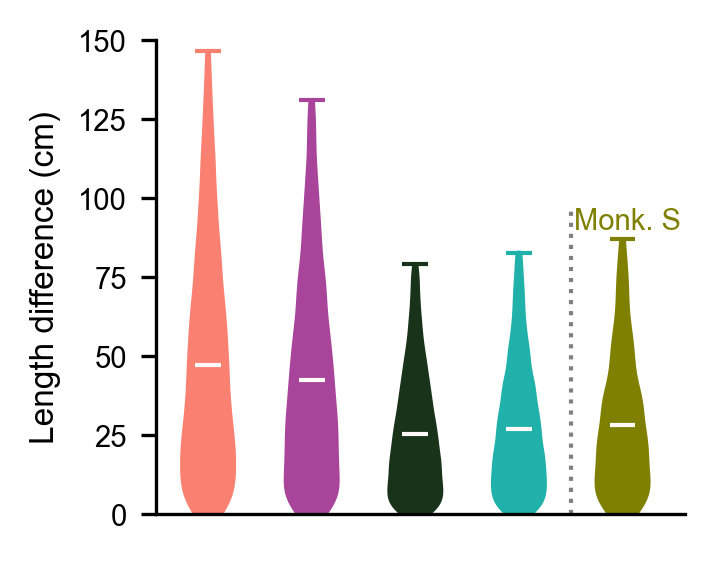

In [73]:
width = 2.2
height = 1.7
violin_width = 0.5

xticks = np.arange(5)
yticks = np.arange(0, 151, 25)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel(r'Length difference (cm)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - violin_width, xticks[-1] + 1.2*violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.yaxis.set_label_coords(-0.18, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    
    colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, monkS_c]
    for (idx, leng), color in zip(enumerate(ydata), colors):
        locals()[f'vp{idx}'] = ax.violinplot(filter_fliers(leng), 
                                             positions=[idx], widths=violin_width, showmeans=True)
        set_violin_plot(locals()[f'vp{idx}'], facecolor=color, edgecolor=color)
        
    plt.xticks([], fontsize=fontsize)
    ax.plot(np.linspace(3.5, 3.5), np.linspace(0, 98), c='gray', ls=':', lw=lw) 
    ax.text(4.05, 90, 'Monk. S', ha='center', fontsize=fontsize, c=monkS_c)
    
    plt.tight_layout(pad=0.1)
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='length_diff'), orientation='portrait', format='pdf', transparent=True)

## S3b

In [74]:
def get_length(agent_data):
    mask = bruno_normal_trajectory.rewarded & schro_normal_trajectory.rewarded
    length = []
    for agent_data_ in agent_data: # loop seeds
        length.append(agent_data_[0][mask])
        
    return np.hstack(length)

In [75]:
ydata = list(map(get_length, [lengths_holistic, lengths_moho, lengths_homo, lengths_modular]))

In [76]:
ydata_holistic = list(map(get_length, [lengths_holisticControlEKF, lengths_modular]))

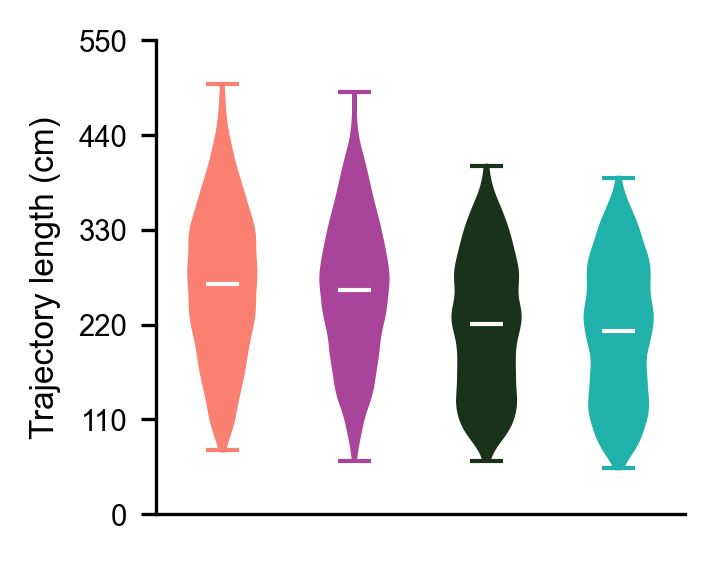

In [77]:
width = 2.2
height = 1.7
violin_width = 0.5

xticks = np.arange(4)
yticks = np.linspace(0, 550, 6)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel(r'Trajectory length (cm)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - violin_width, xticks[-1] + violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.yaxis.set_label_coords(-0.18, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    
    colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
    for (idx, leng), color in zip(enumerate(ydata), colors):
        locals()[f'vp{idx}'] = ax.violinplot(filter_fliers(leng), 
                                             positions=[idx], widths=violin_width, showmeans=True)
        set_violin_plot(locals()[f'vp{idx}'], facecolor=color, edgecolor=color)
        
    plt.xticks([], fontsize=fontsize)
    
    plt.tight_layout(pad=0.1, rect=(0.01, 0, 1.01, 1))
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='sup_length'), orientation='portrait', format='pdf', transparent=True)

## S3e

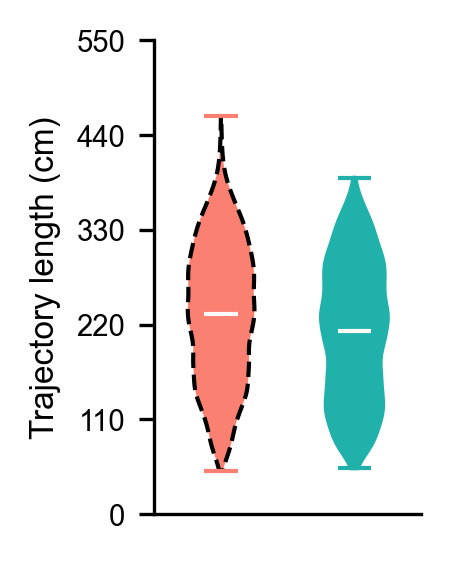

In [78]:
width = 1.4
height = 1.7
violin_width = 0.5

xticks = np.arange(2)
yticks = np.linspace(0, 550, 6)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel(r'Trajectory length (cm)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - violin_width, xticks[-1] + violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.yaxis.set_label_coords(-0.35, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    
    colors = [holistic_c, modular_c]
    ecs = ['k', modular_c]
    lss = ['--', '-']
    for (idx, curv), color, ls, ec in zip(enumerate(ydata_holistic), colors, lss, ecs):
        locals()[f'vp{idx}'] = ax.violinplot(filter_fliers(curv), 
                                             positions=[idx], widths=violin_width, showmeans=True)
        set_violin_plot(locals()[f'vp{idx}'], facecolor=color, edgecolor=ec, ls=ls)
        
    plt.xticks([], fontsize=fontsize)
    
    plt.tight_layout(pad=0.1, rect=(0.01, 0, 1.01, 1))
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='length_diff_holistic'), orientation='portrait', format='pdf', transparent=True)